# Second attempt at prototyping code for fitting models across animals

I realized that in my first attempt (in the script multiple_subject_vae_1) the distributions I was working with in my conditional prior were not a very good choice - they assumed the means of couplings conditioned on neuron properties (e.g., position) could be modeled as Gaussian bumps.  I realized that having weights that fell of in this bump shape from some center was not the best modeling assumption. 

I think a better assumption would be to assume the probability of non-zero couplings to a mode is "bump shaped," but that the distribtion on non-zero couplings can be more flexibly shaped. 

In this notebook, I'm investigating that idea through simulation.   

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch

from multiple_subject_vae_2 import BernoulliBumpCondDistribution
from multiple_subject_vae_2 import CondSpikeSlabDistribution
from multiple_subject_vae_2 import CondGaussianDistribution
from multiple_subject_vae_2 import ConstantRealFcn
from multiple_subject_vae_2 import ConstantLowerBoundedFcn
from multiple_subject_vae_2 import visualize_spike_slab_distribution

## Parameters go here

In [3]:
n_neurons_per_subject = [90, 100, 110, 80, 102] # Length implicitly defines # of subjects

n_smps_per_subject = [1000, 1100, 900, 999, 1230] # Number of (x,y) pairs for each subject

# We model the conditional probability of non-zero couplings as bumps centered at some 
# location in the space of neuron properties (e.g., neuron position).  Here we give the
# centers of these bumps and square matrices which govern how fast the bumps fall off.  
# This is specified for both p and u modes.

# Bump centers 
p_mode_centers = np.asarray([[.2, .2], [.8, .5], [.2, .8]]) 
u_mode_centers = np.asarray([[.2, .2], [.5, .5], [.8, .8]])

# Matrices which determine how fast bumps drop off
p_mode_m = np.asarray([[[.1, 0], [0, .1]], 
           [[.2, 0], [0, .2]],
           [[.3, 0], [0, .3]]])

u_mode_m = np.asarray([[[.1, 0], [0, .1]], 
           [[.2, 0], [0, .2]],
           [[.3, 0], [0, .3]]])

# For the non-zero couplings, we model their distribution as a Normal with some mean
# and variance.  Here we specify the means and variances for each mode
p_nz_means = np.asarray([1, 2, 3.0])
u_nz_means = np.asarray([3.0, 1, 2.0])

p_nz_vars = np.asarray([1, 1, 1.0])
u_nz_vars = np.asarray([1, 1, 1.0])


## Generate data from one spike and slab distribution and fit another with maximum likelihood

In [93]:
# Properties of neurons we condition on 
neuron_props = torch.zeros(200, 2).uniform_()

In [94]:
# Ground truth distribution 
spike_dist = BernoulliBumpCondDistribution(2)
spike_dist.log_ctr_vars.data = torch.tensor([-1, -1.0])
#spike_dist.ctr.data = torch.tensor([0, 1.0])

slab_mn_fcn = ConstantRealFcn(n_dims=1)
slab_mn_fcn.vl.data = torch.tensor([5.0])
slab_std_fcn = ConstantLowerBoundedFcn(n_dims=1, lower_bound=.05)
slab_std_fcn.log_vl.data = torch.tensor([0.0])
slab_dist = CondGaussianDistribution(slab_mn_fcn, slab_std_fcn)

spike_slab_dist = CondSpikeSlabDistribution(spike_dist=spike_dist, slab_dist=slab_dist, d=1)

In [101]:
# Fitted distribution 

f_spike_dist = BernoulliBumpCondDistribution(2)

f_slab_mn_fcn = ConstantRealFcn(n_dims=1)
f_slab_std_fcn = ConstantLowerBoundedFcn(n_dims=1, lower_bound=.05)
f_slab_std_fcn.log_vl.data = torch.tensor([5.0])
f_slab_dist = CondGaussianDistribution(f_slab_mn_fcn, f_slab_std_fcn)

f_spike_slab_dist = CondSpikeSlabDistribution(spike_dist=f_spike_dist, slab_dist=f_slab_dist,
                                              d=1)


In [102]:
## Get samples for true distribution
with torch.no_grad():
    support, nz_vls = spike_slab_dist.sample(neuron_props)

    y = torch.zeros(len(support))
    y[support] = nz_vls
    y = y.unsqueeze(1)

In [103]:
## Fit spike slab distribution with maximum likelihood

params = f_spike_slab_dist.parameters()
optim = torch.optim.Adam(params=params, lr=.01)

for i in range(1000): 
    optim.zero_grad()
    
    nll = -1*f_spike_slab_dist.log_prob(neuron_props, y)
    nll.backward()
    optim.step()
    if i % 100 == 0:
        print('i:' + str(i) + ', nll: ' +  str(nll.detach()))

i:0, nll: tensor(403.6313)
i:100, nll: tensor(302.0439)
i:200, nll: tensor(254.1884)
i:300, nll: tensor(210.4097)
i:400, nll: tensor(171.1443)
i:500, nll: tensor(148.9105)
i:600, nll: tensor(145.7029)
i:700, nll: tensor(145.6624)
i:800, nll: tensor(145.6622)
i:900, nll: tensor(145.6621)


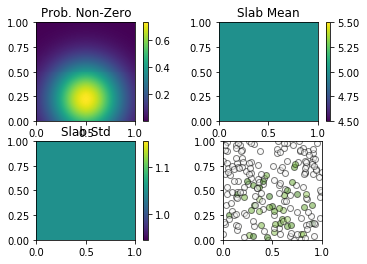

In [104]:
# Visualize True distribution
visualize_spike_slab_distribution(spike_slab_dist, smp_x=neuron_props, smp_y=y.squeeze())

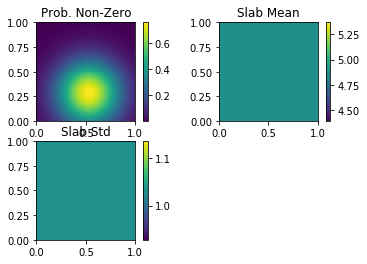

In [105]:
# Visualize Fit distribution
visualize_spike_slab_distribution(f_spike_slab_dist)